# 历史旱涝数据说明



In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

from pathlib import Path
import pandas as pd
import numpy as np

In [2]:
import os
from hydra import compose, initialize

with initialize(version_base=None, config_path="../config"):
    cfg = compose(config_name="config.yaml")
os.chdir(cfg.ds.root)

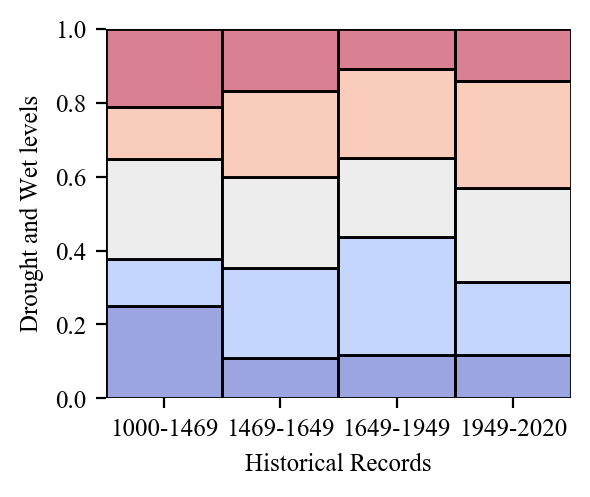

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

from past1000.data import HistoricalRecords
from mksci_font import config_font
from past1000.core.constants import LABELS, STAGES_BINS

palette = plt.get_cmap("coolwarm").reversed()

config_font({"font.size": 9})

# The commented out code is creating an instance of the `HistoricalRecords` class from the `past1000.api.series` module. It is passing the `shp_path` and `data_path` parameters to the constructor of `HistoricalRecords` class using values from `cfg.ds.atlas.shp` and `cfg.ds.atlas.file` respectively.
history = HistoricalRecords(
    shp_path=cfg.ds.atlas.shp,
    data_path=cfg.ds.atlas.file,
    symmetrical_level=True,
)

long_form = history.data.melt(ignore_index=False).reset_index().dropna()

for i, bin in enumerate(STAGES_BINS):
    long_form["stage"] = pd.cut(long_form["year"], bins=STAGES_BINS, labels=LABELS)

fig, ax = plt.subplots(figsize=(3, 2.4))
sns.histplot(
    x="stage",
    hue="value",
    data=long_form,
    multiple="fill",
    stat="count",
    common_norm=True,
    palette=palette,
    ax=ax,
    legend=False,
    alpha=0.5,
)
sns.despine(ax=ax, left=True, bottom=True, trim=True, offset=10)
ax.set_ylabel("Drought and Wet levels")
ax.set_xlabel("Historical Records")
plt.show();

千年之间有记录的年份

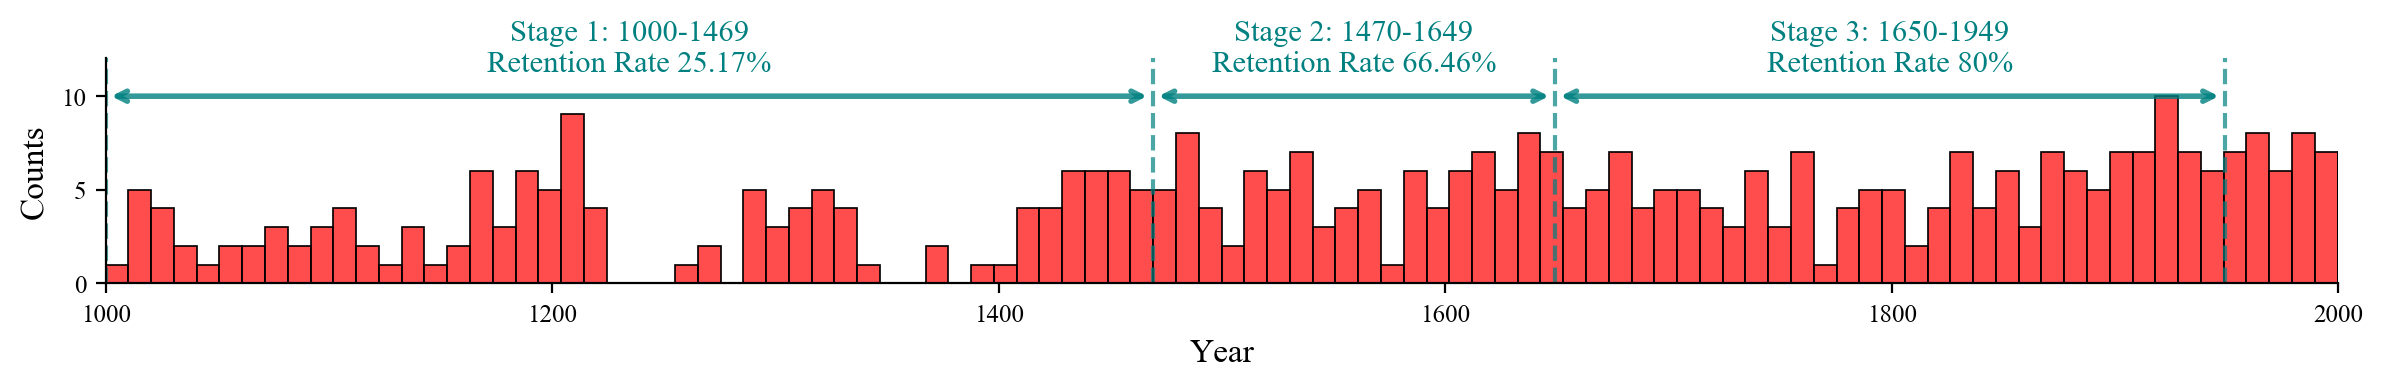

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from mksci_font import config_font
from past1000.core.constants import STAGE_LABELS, STAGES_BINS

config_font({"font.size": 9})

fig, ax = plt.subplots(figsize=(12, 2))

# 绘制历史记录分布
sns.histplot(
    history.loc[history.notna().any(axis=1)].index,
    bins=100,
    ax=ax,
    color="red",
    alpha=0.7,
)

# 阶段分割点
stage_edges = STAGES_BINS[:-1]
stage_labels = STAGE_LABELS[:-1]
arrow_y = ax.get_ylim()[1] * 0.95  # 箭头的y坐标

for i in range(len(stage_edges) - 1):
    x_start = stage_edges[i]
    x_end = stage_edges[i + 1]
    x_mid = (x_start + x_end) / 2

    # 横向双向箭头
    ax.annotate(
        "",
        xy=(x_end, arrow_y),
        xytext=(x_start, arrow_y),
        arrowprops=dict(arrowstyle="<->", color="teal", lw=2, alpha=0.8),
    )
    # 阶段标签
    ax.text(
        x_mid,
        arrow_y + 1,
        stage_labels[i],
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold",
        color="teal",
    )
    # 分割竖线
    if i > 0:
        ax.axvline(x=x_start, color="teal", linestyle="--", alpha=0.7, linewidth=1.5)

# 边界线
ax.axvline(x=stage_edges[0], color="teal", linestyle="--", alpha=0.7, linewidth=1.5)
ax.axvline(x=stage_edges[-1], color="teal", linestyle="--", alpha=0.7, linewidth=1.5)

# 其它美化
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlim(1000, 2000)
ax.set_ylim(0, 12)
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Counts", fontsize=12)
# ax.set_title('Counts of the historical archive', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show();

# 对比重建数据和历史数据

- 历史数据来自《中国千年旱涝图集》
- 重建数据来自 NOAA 的树轮重建数据


Millennial-scale data reveals collective memory of extreme events The impact of extreme weather events such as droughts and floods is intensifying, one important reason being that society quickly forgets past disasters and develops in disaster-prone areas. This collective memory of disasters has significantly affected a society's vulnerability to them. Still, there has long been a lack of data-driven measurements on how long this collective memory lasts. For the first time, we compared historical records with natural reconstructions over a millennium scale in China's Yellow River Basin, demonstrating that the collective memory of extreme climate lasts about 30 years (two generations). The current Earth System Models (ESMs), however, can not have sufficient spatial and temporal resolution to match this pattern, failing to capture the interactions between humans and extreme events. This finding emphasised the necessity of coupling environmental changes with human social systems and improving ESMs for the deep root of the Anthropocene.

## NOAA 树轮重建数据

In [10]:
from past1000.data import load_nat_data

datasets, uncertainties = load_nat_data(
    folder=cfg.ds.noaa,
    includes=cfg.ds.includes,
    start_year=1000,
    standardize=True,
)
datasets.tail()

Directory /Users/songshgeo/Documents/Datasets/东亚古气候重建数据 checked.
Found 18 files in /Users/songshgeo/Documents/Datasets/东亚古气候重建数据.
Found 7 files matching the pattern.


,north-china-precip2010,shanxi2015precip,tan2011precip-noaa,xu2023-asm,qinling2016precip,north-china-temp-precip2011,hexi2019scpdsi
year,,,,,,,
2009,NaN,NaN,NaN,-1.466621,-0.568723,NaN,-0.809462
2010,NaN,NaN,NaN,1.170888,0.307108,NaN,0.515620
2011,NaN,NaN,NaN,1.248765,NaN,NaN,-1.255668
2012,NaN,NaN,NaN,-1.204711,NaN,NaN,NaN
2013,NaN,NaN,NaN,0.140132,NaN,NaN,NaN


In [11]:
from past1000.api.mc import combine_reconstructions, plot_combined_reconstruction
from mksci_font import config_font

combined, trace = combine_reconstructions(datasets, uncertainties)
combined.head()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [true_drought, nu]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.


,mean,sd,hdi_3%,hdi_97%
year,,,,
1000,-0.472,0.451,-1.305,0.364
1001,-0.067,0.465,-0.899,0.838
1002,0.121,0.551,-0.946,1.136
1003,-0.301,0.657,-1.515,0.939
1004,-0.906,0.639,-2.109,0.299


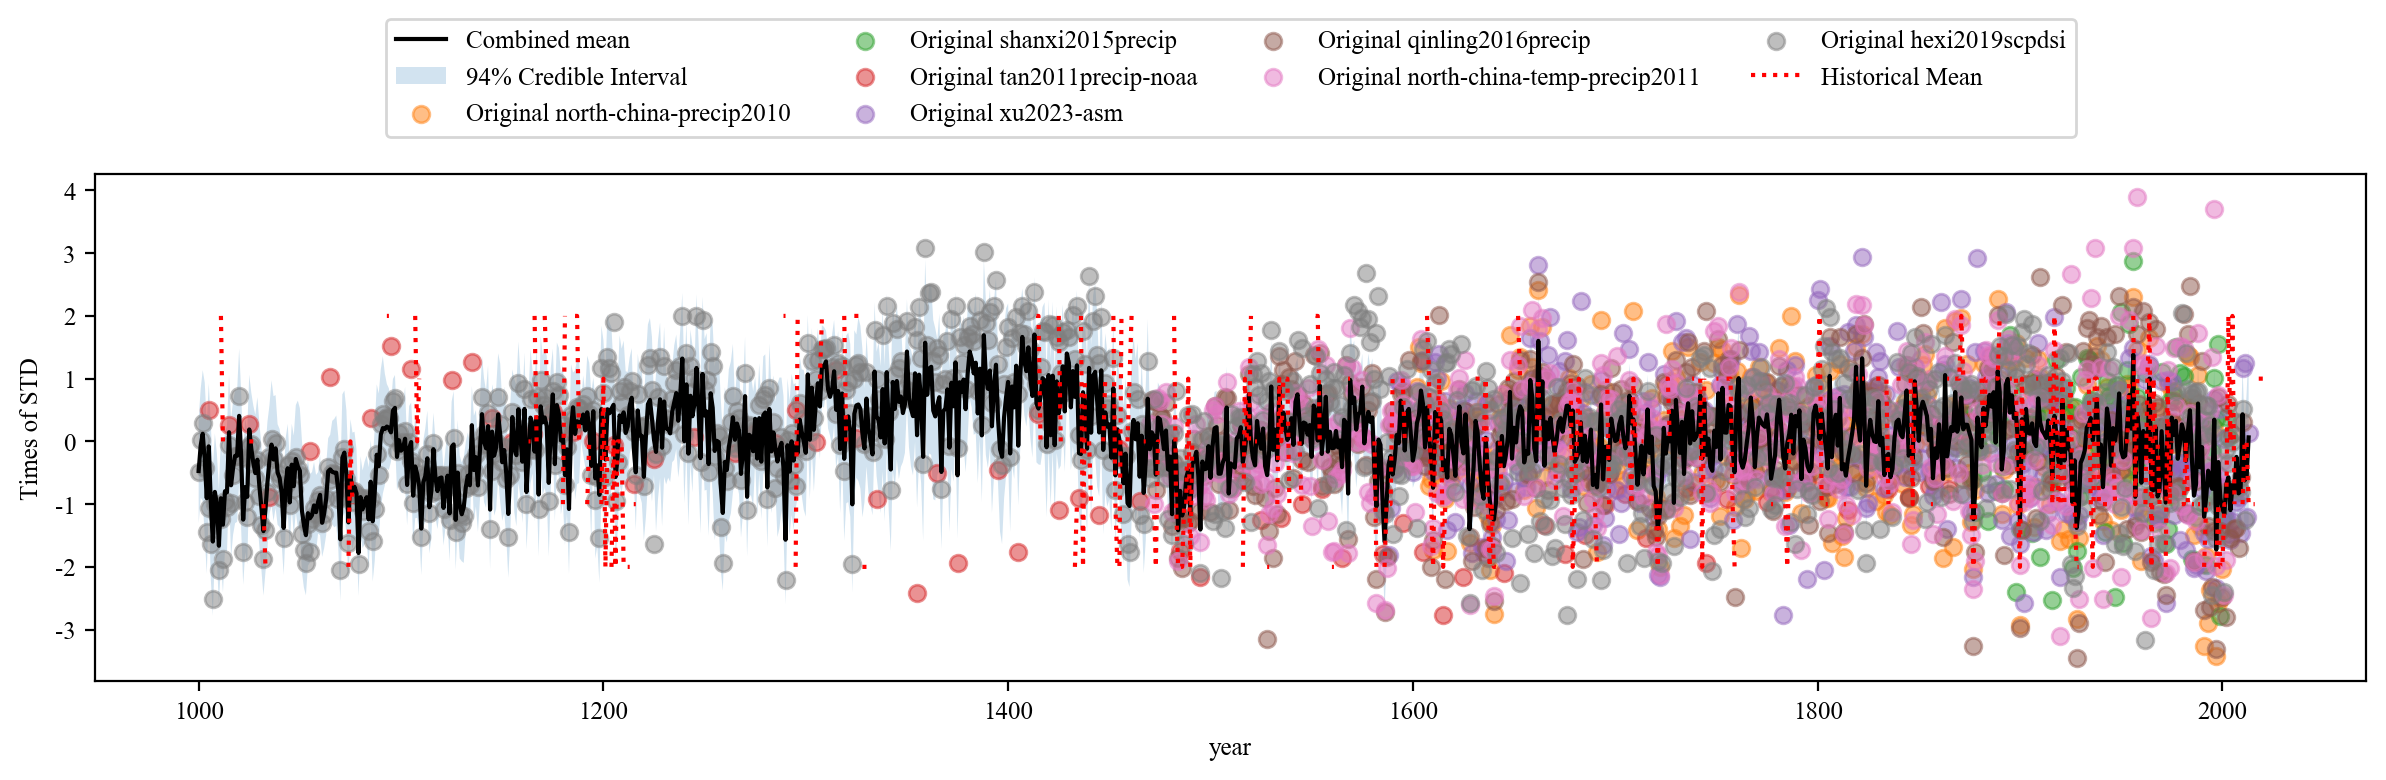

In [12]:
history.to_series(inplace=True, interpolate=None, name="historical_mean", how="mode")
df = history.merge_with(combined, time_range=np.arange(1000, 2000))

ax = plot_combined_reconstruction(combined=combined, data=datasets)
history.plot(ax=ax, color="red", ls=":", label="Historical Mean")
ax.set_ylabel("Times of STD")
ax.legend(ncol=4, loc="lower center", bbox_to_anchor=(0.5, 1.05))
plt.show();

## 历史数据的读取

历史记录与滑动平均后的树轮进行比较

## 双尾滑动

In [13]:
from past1000.utils.calc import detrend_with_nan
import matplotlib.pyplot as plt


history_mean = HistoricalRecords(
    shp_path=cfg.ds.atlas.shp,
    data_path=cfg.ds.atlas.file,
    symmetrical_level=True,
)
history_mean.to_series("mean", inplace=True)
detrend_dropped_nan_history_mean = detrend_with_nan(history_mean)
NATURAL_RECORDS = combined["mean"]
DETREND_N = detrend_with_nan(NATURAL_RECORDS)

我们在中国北方选取了1000-2000年的历史数据，并将其与树轮重建数据进行了对比。我们发现，树轮重建数据与历史数据的相关性在以窗口大小为33到40年之间达到较高水平。

这说明，历史记载倾向于以30年左右的时间尺度感知气候变化。

这里我们还可以用一张综合图来说明情况。

由于一般需要5个样本，计算标准差才有意义，所以我们的 `min_periods` 参数比 `windows` 至少要小 5。













此次实验用的数据是未经过去趋势处理的.
此次实验用的相关性方法是kendall.
r_benchmark: 0.53819
r_benchmark: 0.53819
r_benchmark: 0.54017
r_benchmark: 0.54017


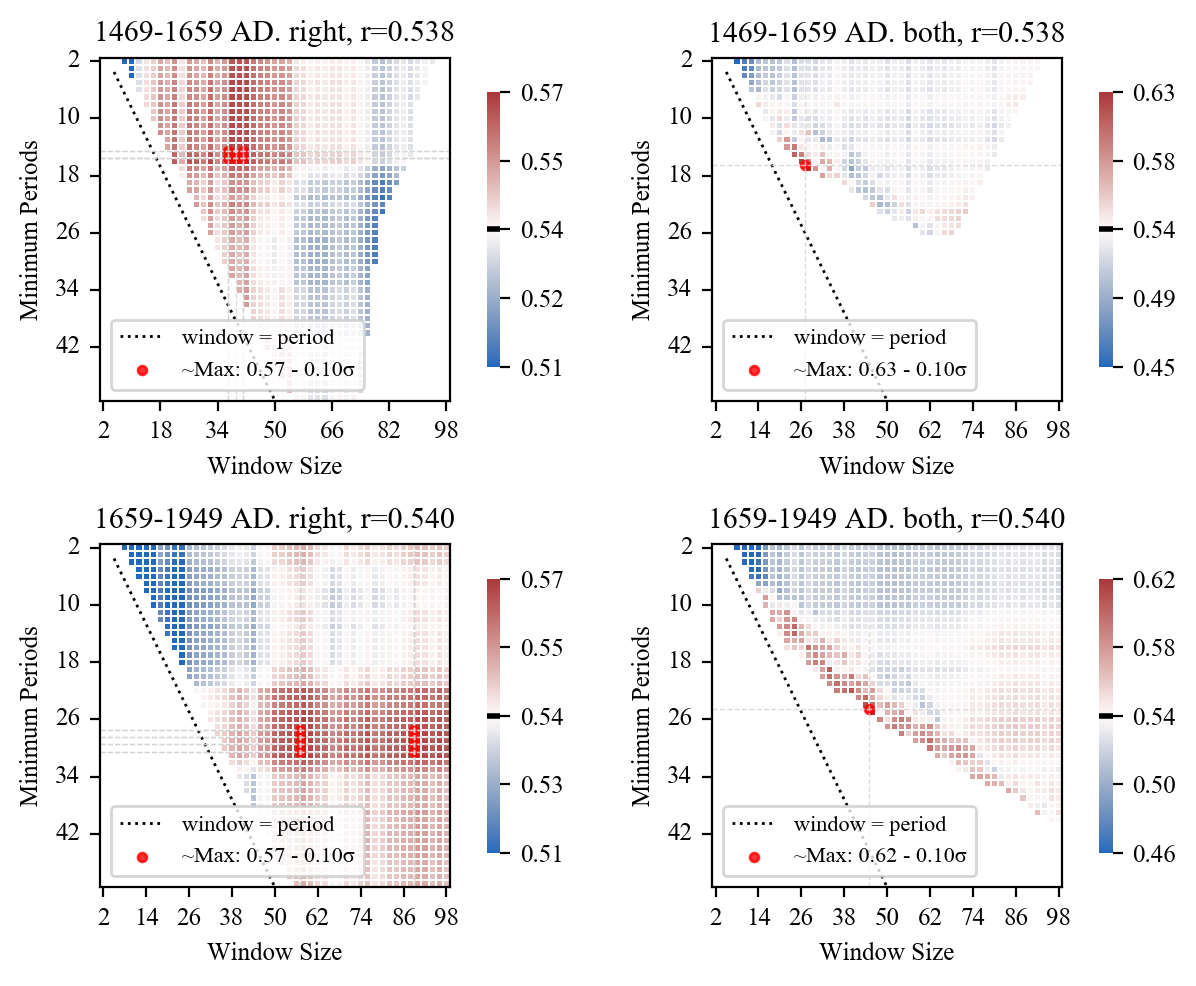

In [17]:
from past1000.compare import experiment_corr_2d
import matplotlib.pyplot as plt
from itertools import product
from past1000.core.constants import STAGE1, STAGE2, END
from past1000.filters import calc_std_deviation

METHOD = "kendall"

fig, axs = plt.subplots(2, 2, figsize=(7, 5), tight_layout=True)
axs = axs.flatten()
# 实验参数
slice1 = slice(STAGE1, STAGE2)
slice2 = slice(STAGE2, END)
change_parameters = product([slice1, slice2], ["right", "both"])
DETREND = True

# 数据
data1 = detrend_dropped_nan_history_mean if DETREND else history_mean.data
data2 = DETREND_N if DETREND else NATURAL_RECORDS

print(f"此次实验用的数据是{'未' if DETREND else '已'}经过去趋势处理的.")
print(f"此次实验用的相关性方法是{METHOD}.")

# 四次对比实验
for i, (slice_now, filter_side) in enumerate(change_parameters):
    ax = axs[i]
    df, r_benchmark, ax = experiment_corr_2d(
        data1=data1,
        data2=data2,
        time_slice=slice_now,
        corr_method=METHOD,
        filter_func=calc_std_deviation,
        filter_side=filter_side,
        ax=ax,
        penalty=False,
        n_diff_w=5,
        std_offset=0.1,
    )
    ax.set_title(
        f"{slice_now.start}-{slice_now.stop} AD. {filter_side}, r={r_benchmark:.3f}"
    )
    ax.locator_params(axis="both", nbins=9)  # x轴最多9个主刻度
    ax.tick_params(axis="both", rotation=0)
plt.show();

可以见到，两个都进行滤波的时候，还是可以显著提高相关性的

### 测试其它的滤波方法

可以见到，两个都进行滤波的时候，还是可以显著提高相关性的

最关键的是把历史时期的值进行滤波~